# Prize-Collecting Steiner Tree (PCSTP)

## Libs Importing

In [1]:
import sys
import os
import time
import networkx as nx

sys.path.insert(1, os.path.realpath(os.path.pardir))

In [2]:
from pcstp.instances.generator import generate_random_steiner
from pcstp.utils.draw import draw_steiner_graph

## Experiments

In [3]:
SEED = 100

In [4]:
G, (nodes, edges, position_matrix, edges_cost, terminals, prizes) = generate_random_steiner(
    num_nodes=25,
    num_edges=20,
    max_node_degree=10,
    min_prize=0,
    max_prize=100,
    num_terminals=5,
    min_edge_cost=0,
    max_edge_cost=10,
    cost_as_length=False,
    max_iter=100,
    seed=SEED
)

terminals:  (5,)
prizes:  (5,)


In [5]:
from pcstp.steinertree import SteinerTreeProblem
from pcstp.instances.reader import SteinlibReader, DatReader
from pcstp.solver.base import computes_steiner_cost

The instance can be imported from a file or generated through the instance generator presented above.

In [6]:
stp = SteinerTreeProblem(graph=G, terminals=terminals)

In [7]:
from pcstp.solver.base import computes_steiner_cost

In [8]:
from pcstp.utils.graph import preprocessing

In [9]:
filename = '../data/instances/dat/steinc1-wmax_10-seed_33000-gw.dat.red'

if filename.endswith('.stp'):
    stp_reader = SteinlibReader()
else:
    stp_reader = DatReader()

stp = stp_reader.parser(filename=filename)


In [10]:
print("Nodes: ", len(stp.graph.nodes))
print("Edges: ", len(stp.graph.edges))
print("Terminals: ", stp.terminals)

Nodes:  116
Edges:  214
Terminals:  {116, 93, 39}


In [11]:
G, terminals = preprocessing(stp.graph, stp.terminals)

In [12]:
stp_preprocessed = SteinerTreeProblem(graph=G, terminals=terminals)

In [13]:
print("Nodes: ", len(stp_preprocessed.graph.nodes))
print("Edges: ", len(stp_preprocessed.graph.edges))
print("Terminals: ", stp_preprocessed.terminals)

Nodes:  116
Edges:  214
Terminals:  {116, 93, 39}


## Solution obtained with NetworkX Steiner Tree Approximation Algorithm

In [14]:
# %%timeit -n 100

start_time = time.time()

nx_steiner_tree = nx.algorithms.approximation.steinertree.steiner_tree(
    stp.graph,
    stp.terminals,
    weight='cost'
)

networkx_duration = time.time() - start_time
networkx_cost = computes_steiner_cost(stp.graph, nx_steiner_tree, stp.terminals)
print(f'Cost: {networkx_cost}')


Cost: 54


In [15]:
print(f'Duration: {networkx_duration*1000} ms')

Duration: 40.14134407043457 ms


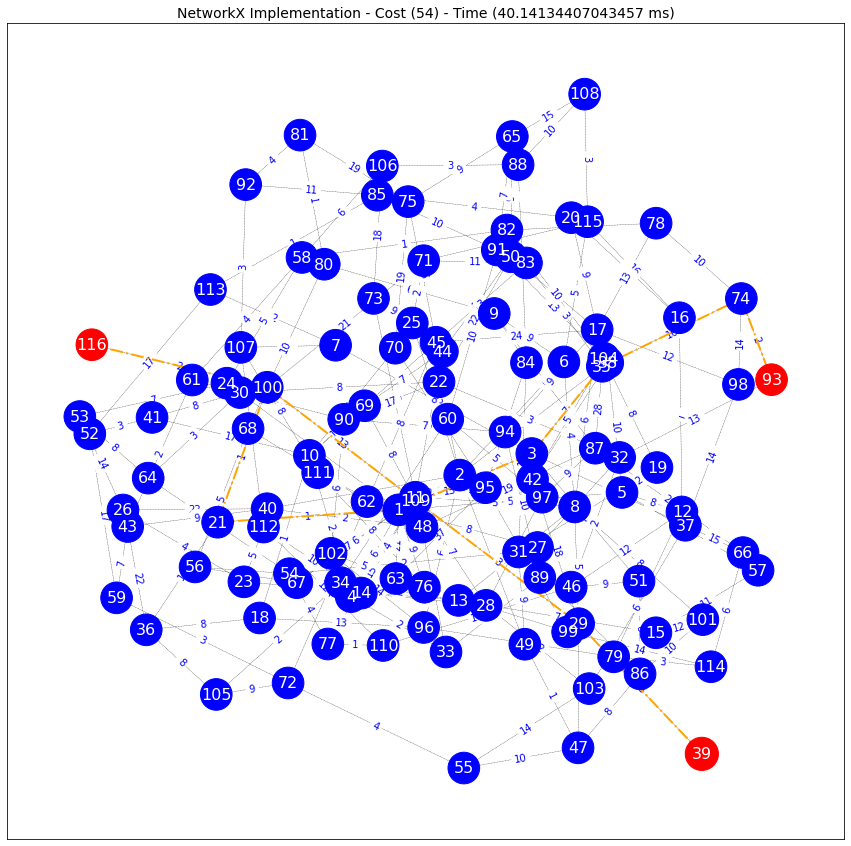

In [16]:
try:
    draw_steiner_graph(
        stp.graph,
        steiner_graph=nx_steiner_tree,
        plot_title=f'NetworkX Implementation - Cost ({networkx_cost}) - Time ({networkx_duration * 1000} ms)',
        node_label='name',
        seed=SEED
    )
except Exception as e:
    print(e)


## Solution obtained with Ant Colony Optimization

In [17]:
from pcstp.solver.aco import AntColony

In [18]:
# %%timeit -n 100

solver = AntColony(
    graph=stp_preprocessed.graph,
    terminals=stp_preprocessed.terminals,
    iterations=100,
    num_ants=1,
    evaporation_rate=0.2,
    alpha=1.0,
    beta=1,
    beta_evaporation_rate=0.4,
    initial_pheromone=0.1,
    pheromone_amount=1,
    pheromone_initialization_strategy='same_value',
    choose_best=0.3,
    log_level='info',
    early_stopping=None,
    seed=SEED
)
steiner_tree, steirner_cost = solver.solve()


2022-01-28 19:52:43,888 - [aco.py:237] - INFO - Best Iteration: 21 - Best Cost: 110


In [19]:
print(f'Cost: {steirner_cost}')

Cost: 110


In [20]:
print(f'Duration: {solver._duration * 1000} ms')

Duration: 2318.674325942993 ms


In [21]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Steiner Cost')

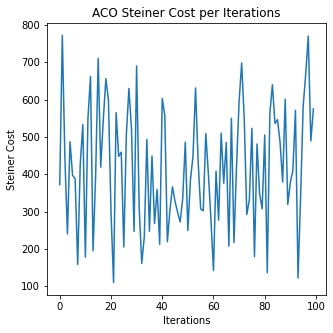

In [22]:

fig, ax = plt.subplots(1, 1,figsize=(5,5))

ax.plot(solver.history)
ax.set_title("ACO Steiner Cost per Iterations")
ax.set_xlabel("Iterations")
ax.set_ylabel("Steiner Cost")

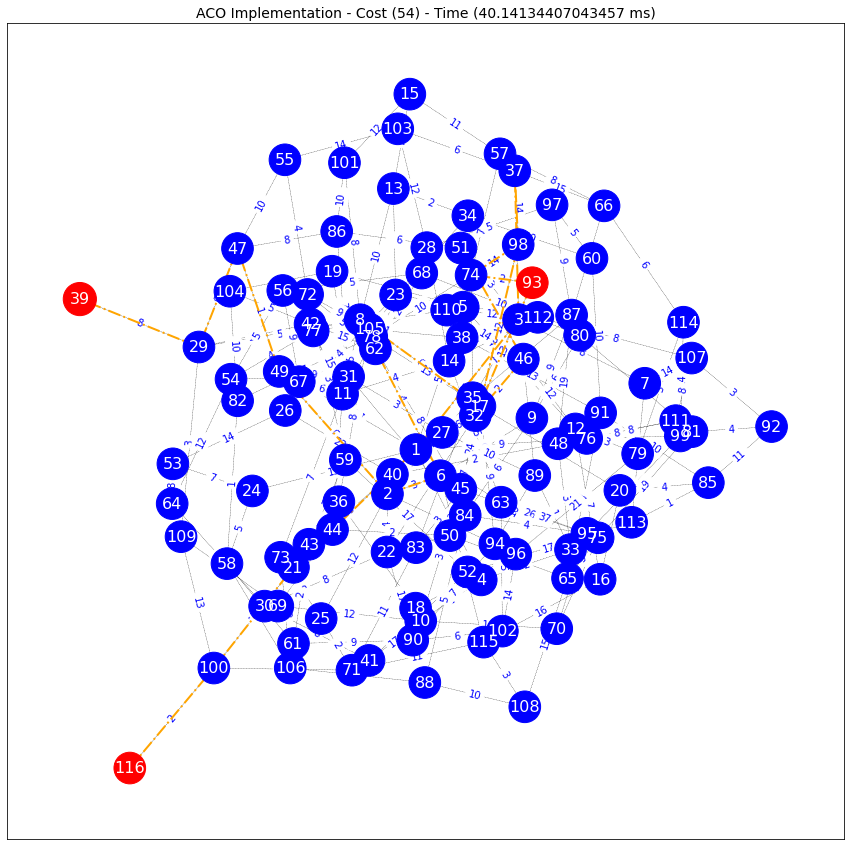

In [23]:
try:
    draw_steiner_graph(
        stp_preprocessed.graph,
        steiner_graph=steiner_tree,
        plot_title=f'ACO Implementation - Cost ({networkx_cost}) - Time ({networkx_duration * 1000} ms)',
        node_label='name'
    )
except:
    pass


In [24]:
steiner_tree.nodes

NodeView((116, 100, 21, 1, 3, 51, 46, 32, 93, 74, 98, 37, 17, 8, 6, 2, 49, 47, 29, 39))